In [1]:
import numpy as np
import jax.numpy as jnp
import cvxpy as cp

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import seaborn_image as isns

import sys
sys.path.append('../')
import grid_utils as util

plt.rcParams['figure.dpi'] = 300

## Fig 1

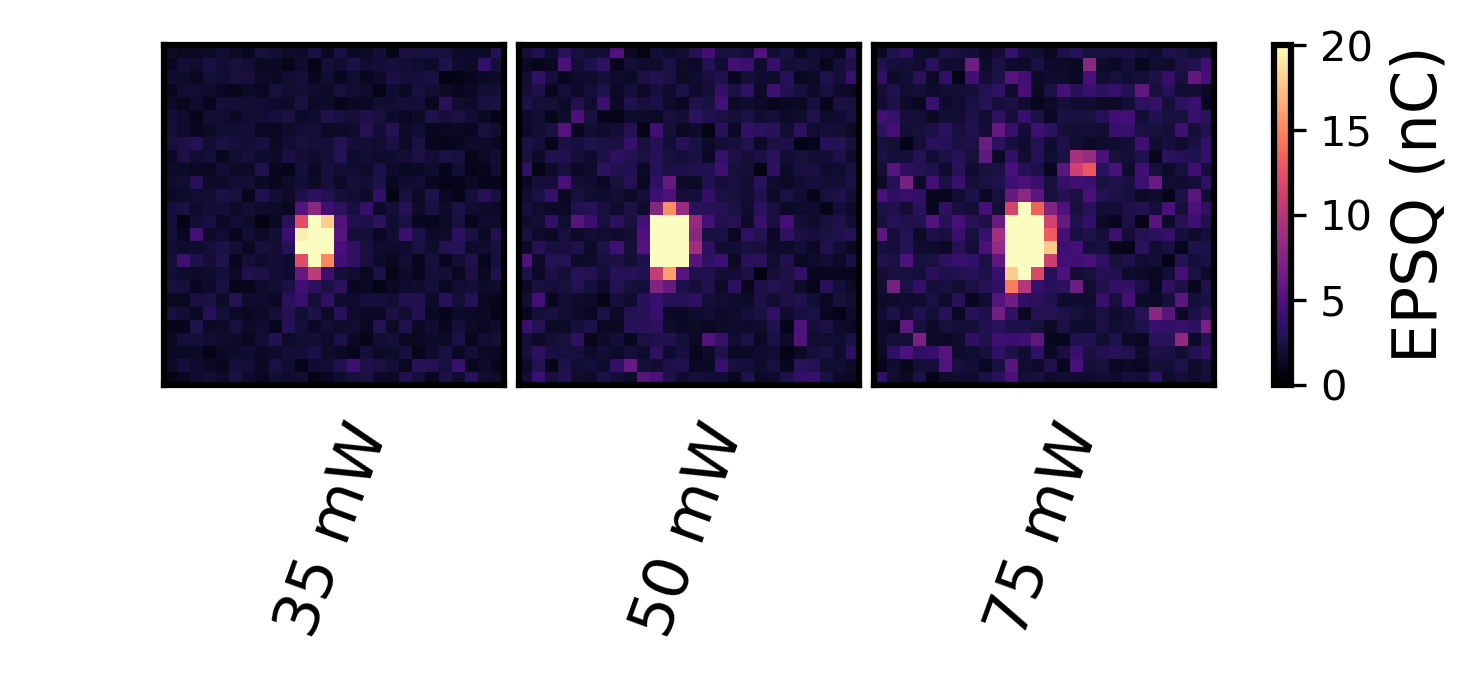

In [10]:
data_path = '../data/marta/IV_injected_sparse/preprocessed/220214_cell2_mg_A_planes.npz'
dat = np.load(data_path, allow_pickle='True')

pscs, I, L = dat['psc'], dat['I'], dat['L']
y = pscs.sum(1)
grid_mean, _, num_stims = util.make_suff_stats(y, I, L)


fig = plt.figure(figsize=(6, 0.75 * 2), dpi=300, facecolor='white')

util.plot_multi_means(fig,
    [grid_mean], np.arange(1),
#     map_names=['subtracted'],
    cmaps=['magma', 'magma'],
    cbar_labels=['EPSQ (nC)'],
    vranges=[(0,20)],
    powers=np.unique(I))

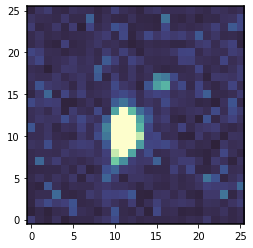

In [19]:
plt.imshow(grid_mean[-1,:,:,-1], vmin=0, vmax=20)

Text(0, 0.5, 'current (nA)')

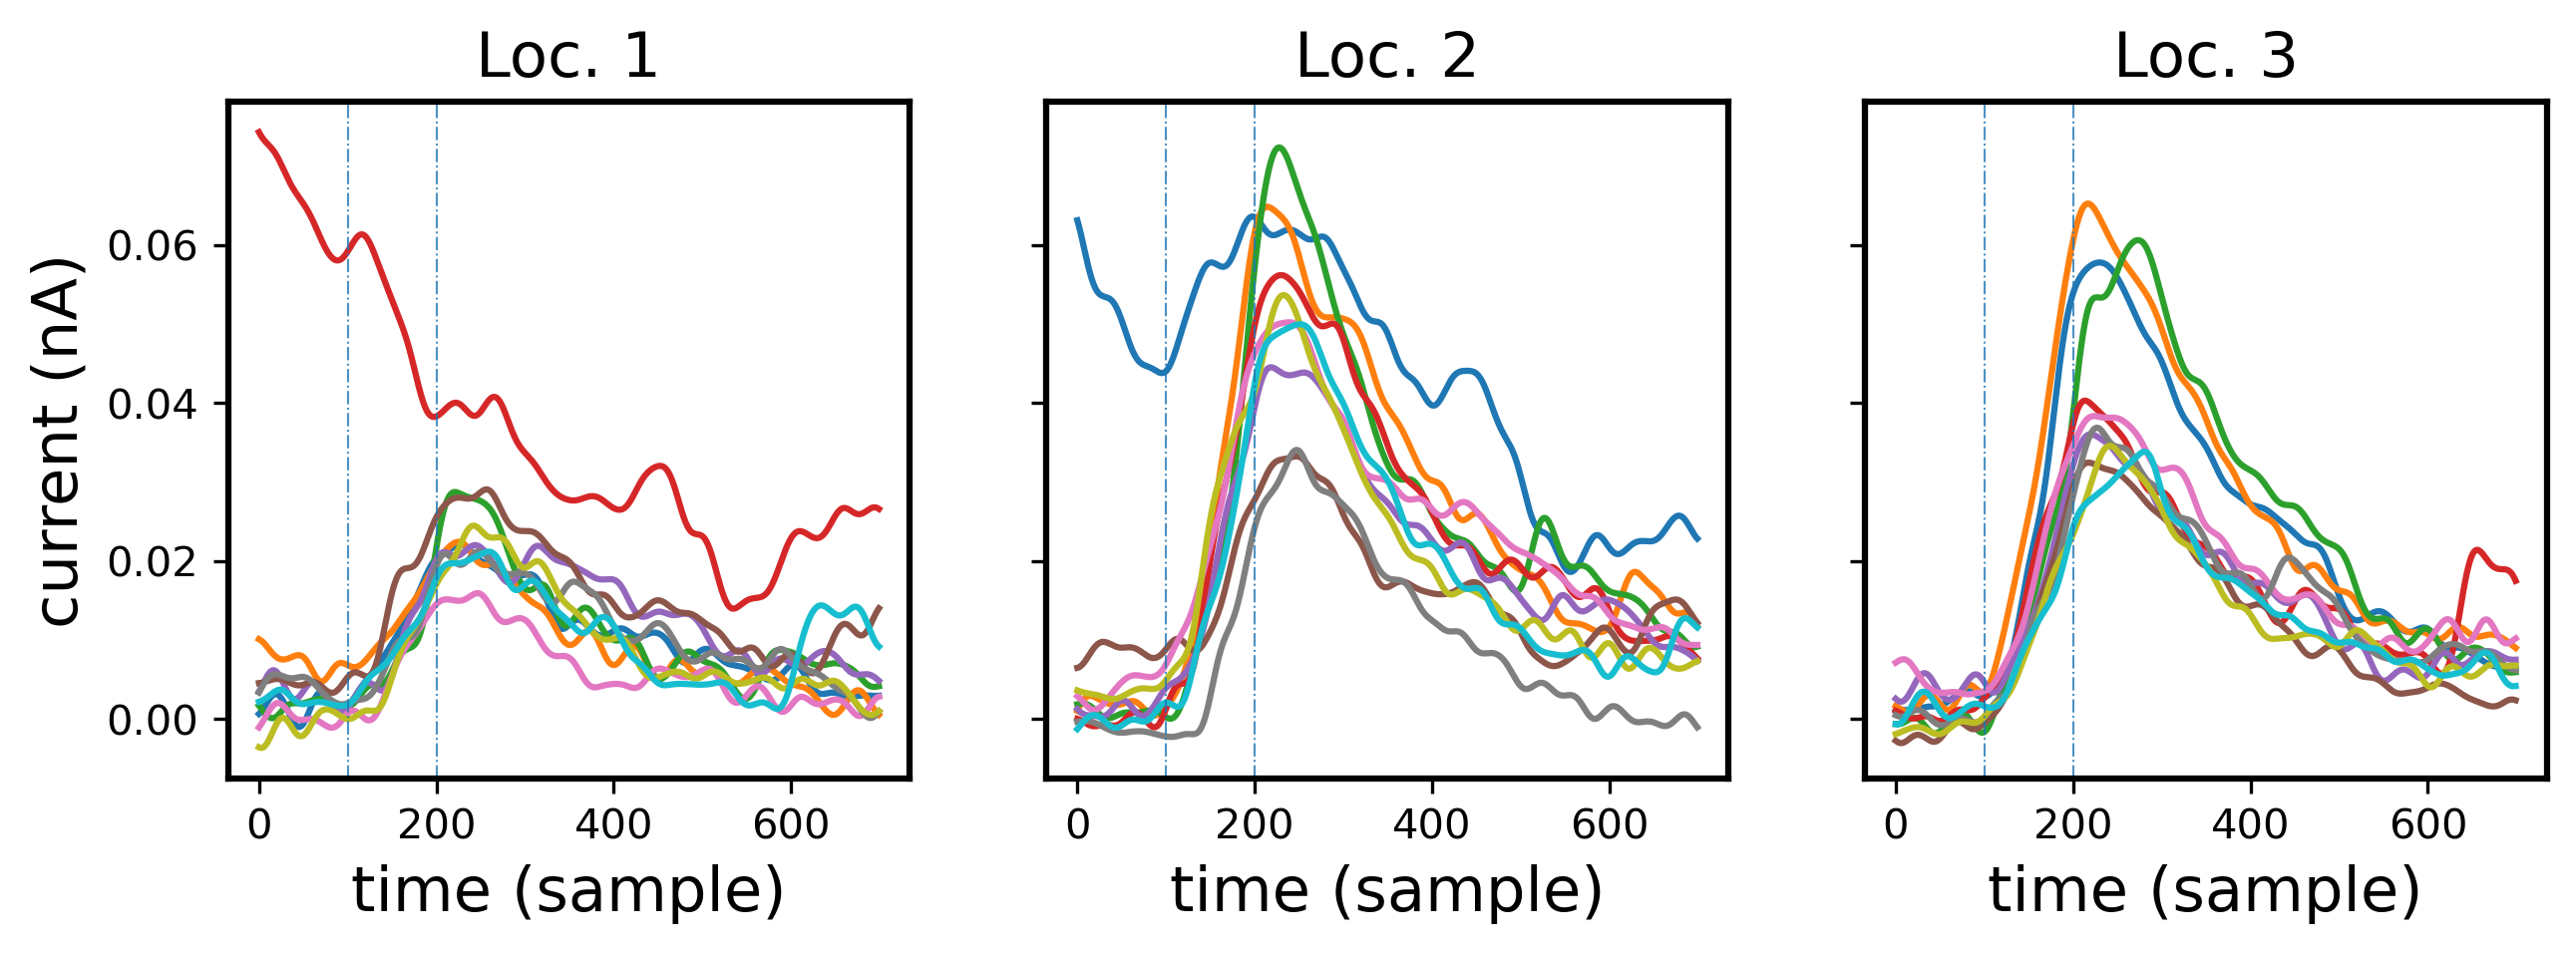

In [37]:
psc_tensor = util.make_psc_tensor(pscs, I, L)
ps = np.arange(3)
xs = np.arange(5,15)
ys = np.arange(7,15)
zs = -1
t_max = 700
y_idx = 6
x_offset = 4

P, X, Y, Z = np.meshgrid(ps, xs, ys, zs, indexing='ij')
roi_tensor = psc_tensor[P,X,Y,Z,:,0:t_max]


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharey=True, dpi=300, sharex=True)
for i in range(3):
        axs[i].plot(roi_tensor[-1,i+x_offset,y_idx,...].reshape(-1,t_max).T)
        axs[i].axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)
        axs[i].axvline(x=200, linestyle='-.', linewidth=0.5, alpha=0.8)
        
        axs[i].set_title('Loc. %d' % (i + 1))
        axs[i].set_xlabel('time (sample)')
axs[0].set_ylabel('current (nA)')

## Fig 2

- run parafac separately across all depths, powers

In [38]:
import tensorly as tl
from tensorly.decomposition import parafac

def estimate_photocurrents(roi_tensor, separate_by_powers=True, rank=1, l2_reg=0.0):
    npowers, nx, ny, nz, ntrials, ntimesteps = roi_tensor.shape


    subtracted = np.copy(roi_tensor)
    full_est = np.copy(roi_tensor)
    
    for z_idx in range(nz):

        for power_idx in range(npowers):

            # extract current tensor we're working with. Different powers
            # can have different numbers of trials, which are marked by np.nan
            try:
                ntrials_curr = np.where(np.isnan(roi_tensor[power_idx, 0, 0, 0, :, 0]))[0][0]
            except IndexError:
                ntrials_curr = ntrials

            # This forms an index to extract a particular (power, trials, plane) combination
            _slice = np.s_[power_idx, :, :, z_idx, 0:ntrials_curr, :]
            
            tensor_curr = roi_tensor[_slice].reshape(-1, ntrials_curr, ntimesteps)

            # form rank1 approx and subtract
            cptensor = parafac(np.maximum(tensor_curr, 0),
                               rank=rank,)

            est = tl.cp_to_tensor(cptensor).reshape(nx, ny, ntrials_curr, ntimesteps)
            subtracted[_slice] = roi_tensor[_slice] - est
            full_est[_slice] = est


    return full_est, subtracted



In [39]:
est_roi_tensor, subtracted_roi_tensor = estimate_photocurrents(roi_tensor)

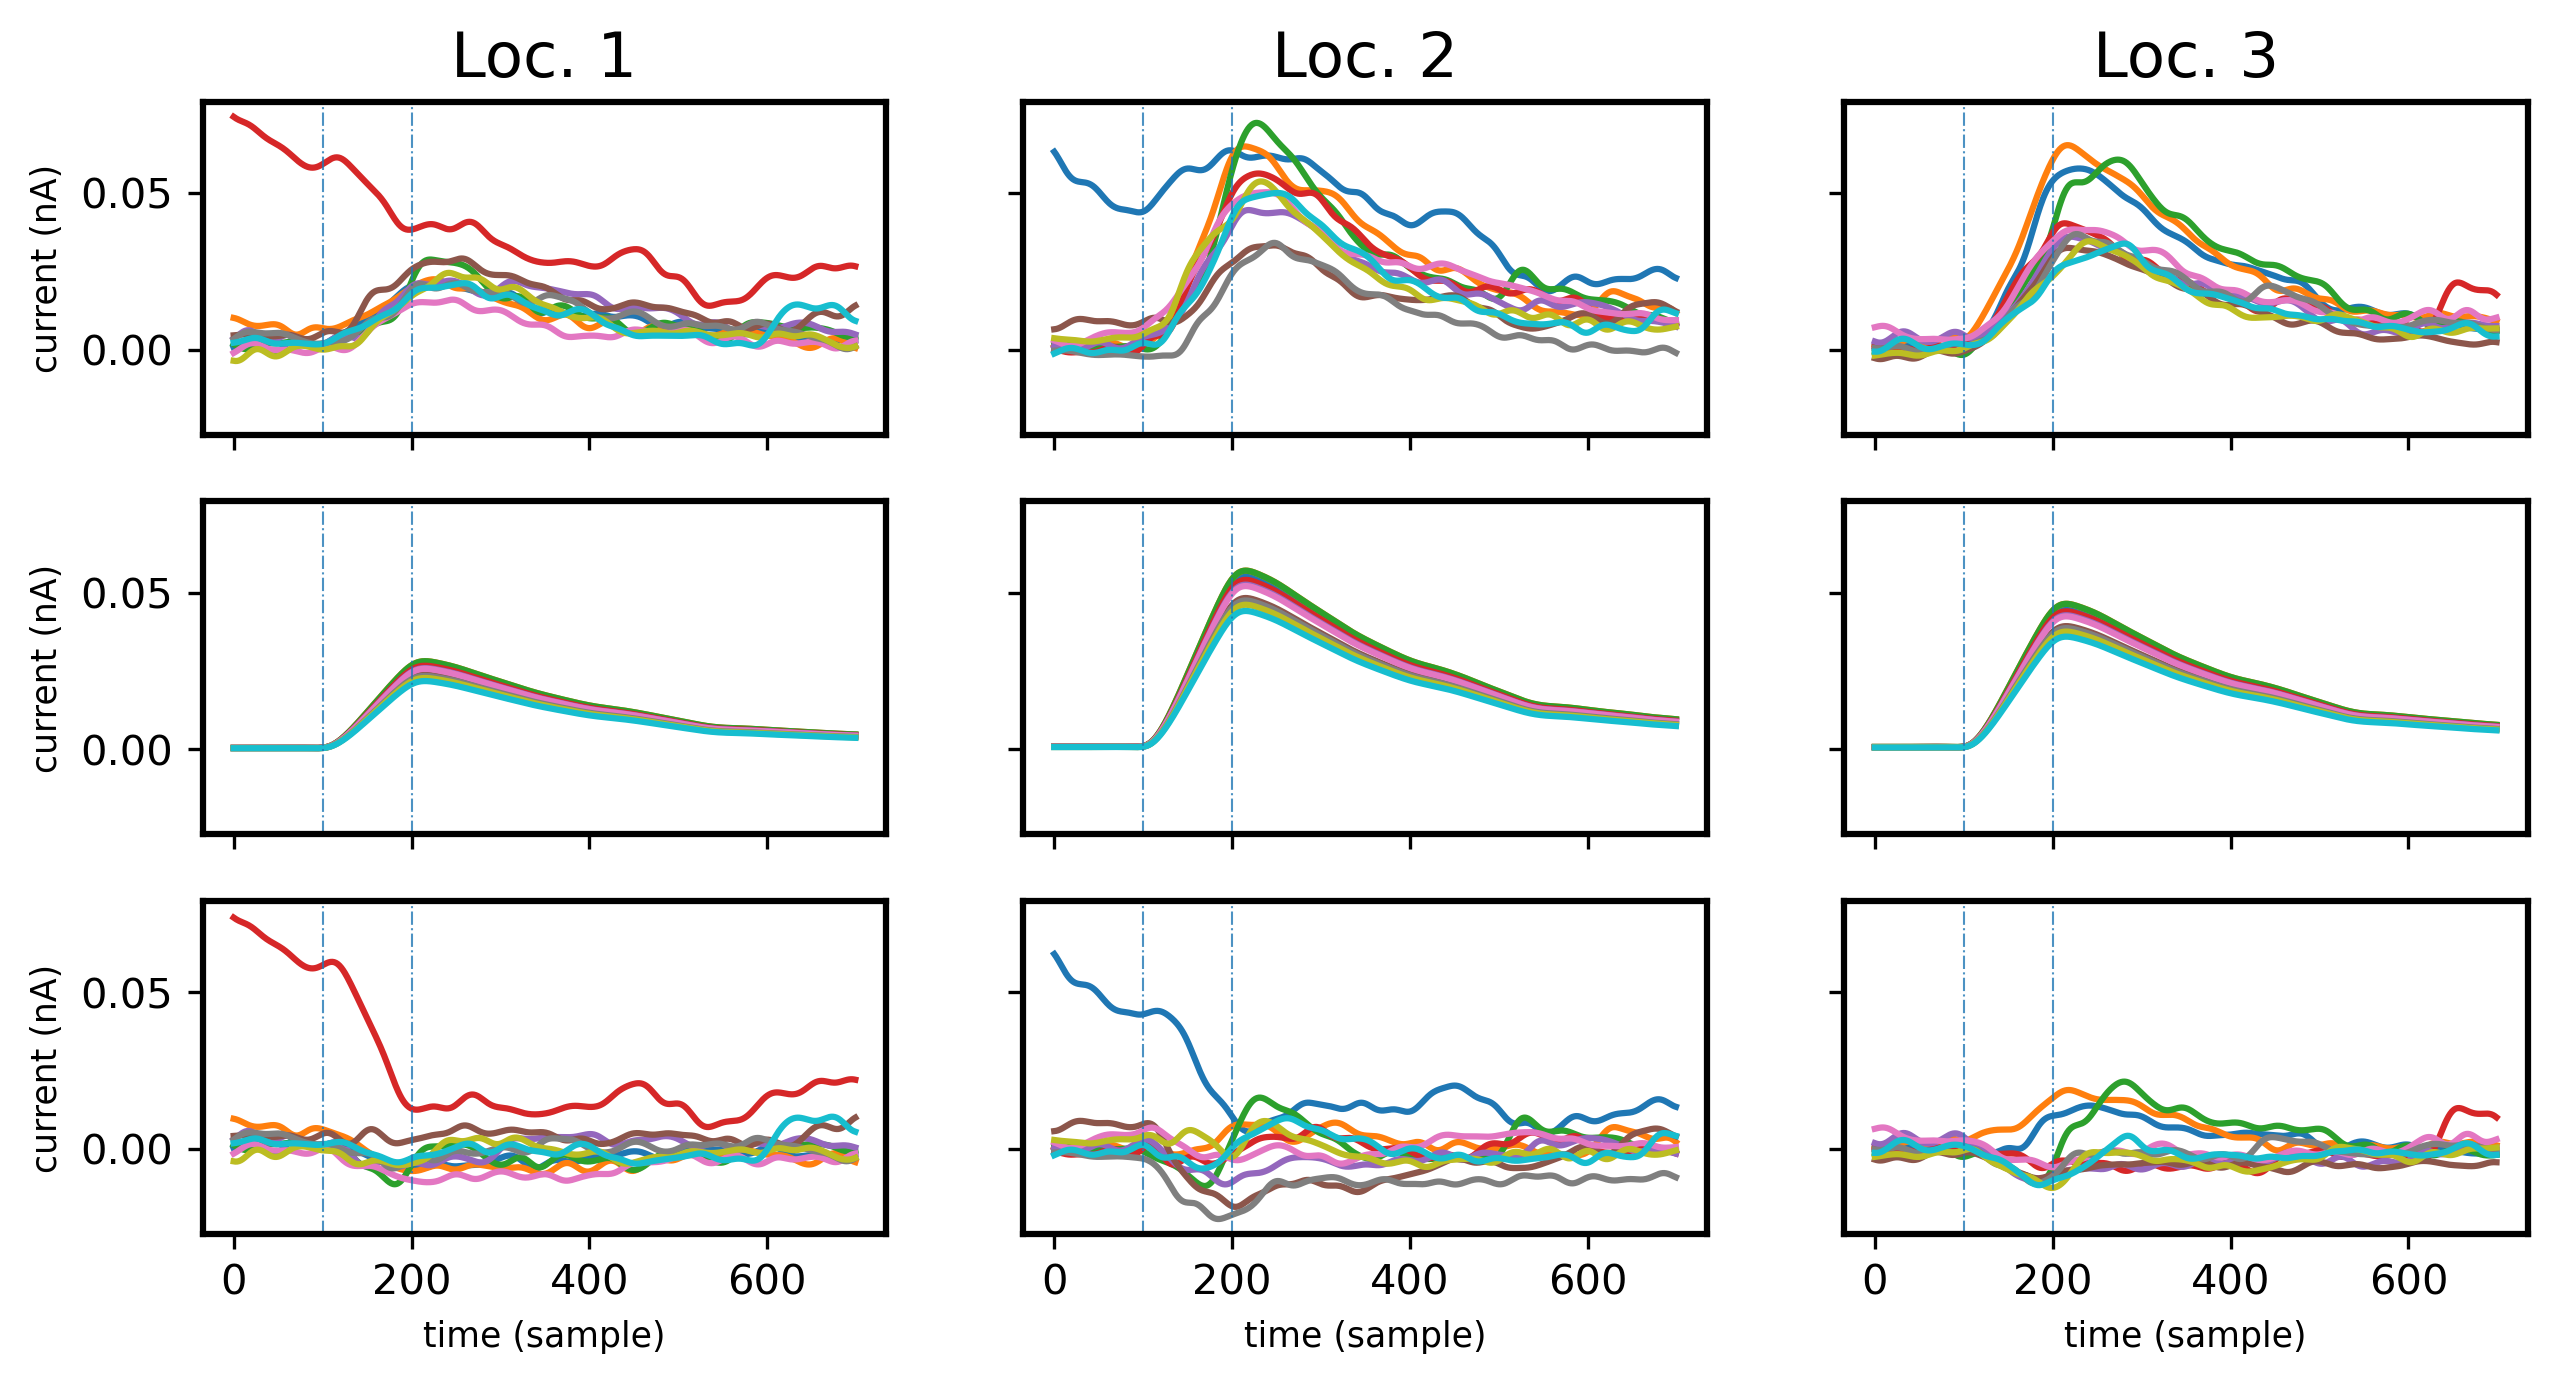

In [40]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,5), sharey=True, dpi=300, sharex=True)
y_idx = 6
x_offset = 4

for i in range(3):
        
        # plot raw
        axs[0, i].plot(roi_tensor[-1,i+x_offset,y_idx,...].reshape(-1,t_max).T)
        axs[0, i].axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)
        axs[0, i].axvline(x=200, linestyle='-.', linewidth=0.5, alpha=0.8)
        
        axs[0, i].set_title('Loc. %d' % (i + 1))
        axs[0, 0].set_ylabel('current (nA)', fontsize='small')
        
        # plot estimate
        axs[1, i].plot(est_roi_tensor[-1,i+x_offset,y_idx,...].reshape(-1,t_max).T)
        axs[1, i].axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)
        axs[1, i].axvline(x=200, linestyle='-.', linewidth=0.5, alpha=0.8)
        axs[1, 0].set_ylabel('current (nA)', fontsize='small')
        
        # plot subtracted
        axs[2, i].plot(subtracted_roi_tensor[-1,i+x_offset,y_idx,...].reshape(-1,t_max).T)
        axs[2, i].axvline(x=100, linestyle='-.', linewidth=0.5, alpha=0.8)
        axs[2, i].axvline(x=200, linestyle='-.', linewidth=0.5, alpha=0.8)
        
        axs[2, 0].set_ylabel('current (nA)', fontsize='small')
        
        axs[2, i].set_xlabel('time (sample)', fontsize='small')
# axs[0].set_ylabel('current (nA)')

In [41]:
psc_tensor_subtracted = psc_tensor.copy()
psc_tensor_subtracted[P,X,Y,Z,:,0:t_max] = subtracted_roi_tensor
mean_map_subtracted = np.nansum(np.nanmean(psc_tensor_subtracted, axis=-1), axis=-1)

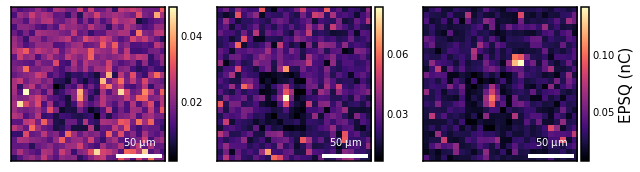

In [42]:
img_grid = isns.ImageGrid(
    [x.squeeze() for x in mean_map_subtracted], origin='lower', cmap='magma',
     dx=6.5, units="um", cbar_label=[None, None, 'EPSQ (nC)'], figure=fig)

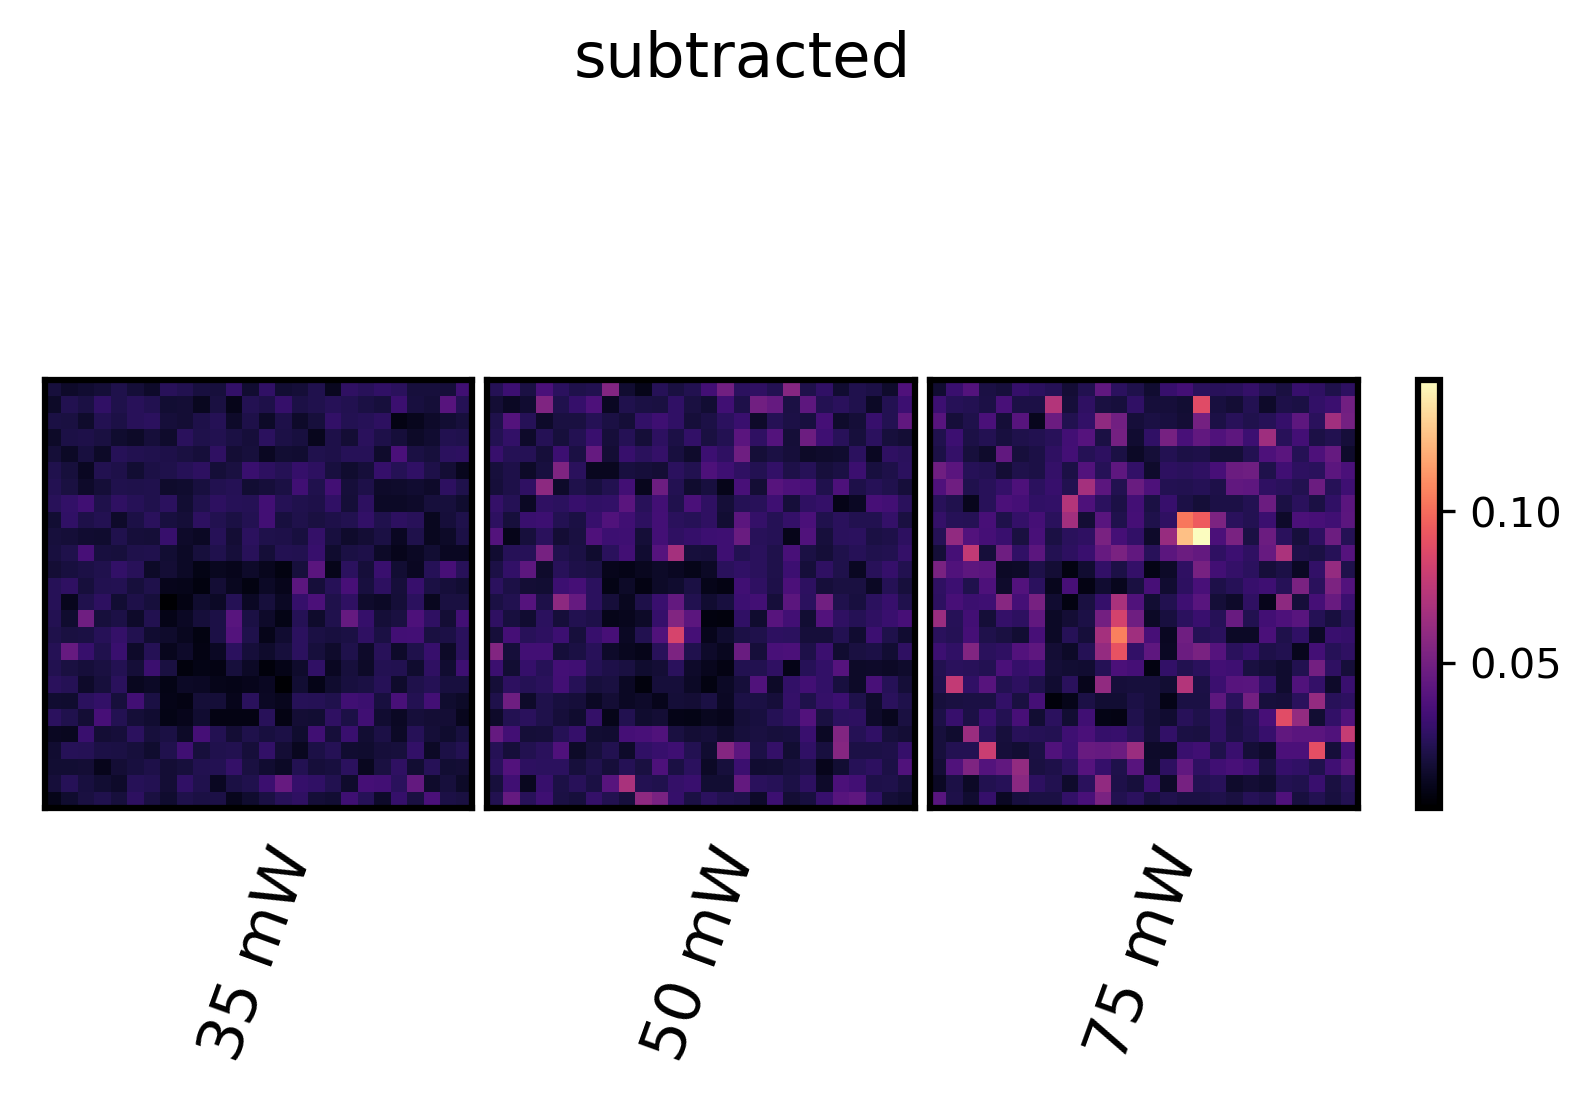

In [43]:

fig = plt.figure(figsize=(6, 0.75 * 5), dpi=300, facecolor='white')

util.plot_multi_means(fig,
    [mean_map_subtracted], np.arange(1),
    map_names=['subtracted'],
    cmaps=['magma', 'magma'],
#     cbar_labels=['EPSQ (nC)', 'EPSQ (nC)',],
    powers=np.unique(I))